In [1]:
import os
import json
from sage.config.config import DataArguments, TrainingArguments, MiscArguments

from sage.config import get_logger, logger_conf
from sage.data import get_dataloader
from sage.models import build_model
from sage.utils import seed_everything

from nilearn import plotting
import nibabel
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/envs/research/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_args, training_args, misc_args = (
    DataArguments(),
    TrainingArguments(),
    MiscArguments(),
)

path = "../result/[20220521-1538]resnetlr0.0001warmup10%/"
config_file = os.path.join(path, "config.json")
with open(config_file, "r") as f:
    config = json.load(f)

In [3]:
data_args.load(config["data_args"])
training_args.load(config["training_args"])
misc_args.load(config["misc_args"])

In [4]:
seed_everything(misc_args.seed)
misc_args.output_dir = "./"
# data_args.batch_size = 1

logger_conf["handlers"]["file_handler"]["filename"] = misc_args.output_dir + "/run.log"
logger = get_logger(logger_conf)

train_dataloader = get_dataloader(data_args, misc_args, "train", logger)
valid_dataloader = get_dataloader(data_args, misc_args, "valid", logger)
test_dataloader = get_dataloader(data_args, misc_args, "test", logger)

2022-05-28 23:34:02,256 - root - INFO - Initialize dataset.
2022-05-28 23:34:02,401 - root - INFO - Successfully setup 1044 brains for Train
2022-05-28 23:34:02,403 - root - INFO - Initialize dataset.
2022-05-28 23:34:02,421 - root - INFO - Successfully setup 262 brains for Valid
2022-05-28 23:34:02,423 - root - INFO - Initialize dataset.
2022-05-28 23:34:02,440 - root - INFO - Successfully setup 146 brains for Test


In [5]:
import torch
from sage.models import build_model

model = build_model(training_args, logger)
model = model.to("cpu")

model_path = os.path.join(path, "ckpts", "ep070.pt")
model.load_state_dict(torch.load(model_path))

2022-05-28 23:34:03,257 - root - INFO - Resnet was chosen.
2022-05-28 23:34:05,535 - root - INFO - Resnet has #params: 4 M.


<All keys matched successfully>

In [7]:
from captum.attr import LayerGradCam, LayerAttribution

attributer = LayerGradCam(model, model.conv_layers()[0])

In [8]:
preds = []
model = model.to("cpu")
for x, y in test_dataloader:

    attr = attributer.attribute(x[0][None, ...])
    break

In [9]:
def z_norm(tensor):

    assert tensor.ndim == 3, f"Give 3-dimensional tensor. Given {tensor.shape}."

    mu = tensor.mean()
    sigma = tensor.var().sqrt()

    return (tensor - mu) / sigma

In [10]:
cut_coords = (48, 48, 48)

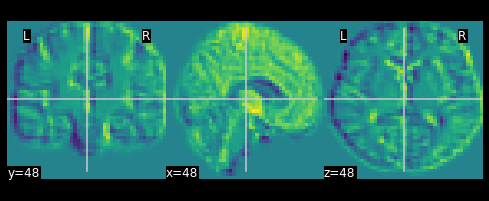

In [11]:
upsampled = LayerAttribution.interpolate(
    attr, (96, 96, 96), interpolate_mode="nearest"
).cpu()
z_normed = z_norm(upsampled[0][0])

_nifti = lambda arr: nibabel.nifti1.Nifti1Image(arr, np.eye(4))

display = plotting.plot_anat(_nifti(x[0][0].detach().numpy()), cut_coords=cut_coords)
display.add_overlay(_nifti(z_normed.detach().numpy()))

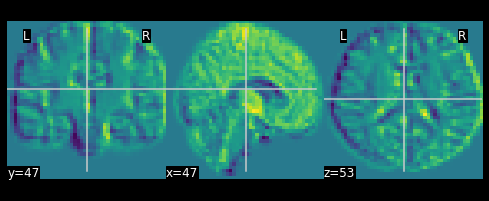

In [12]:
upsampled = LayerAttribution.interpolate(
    attr, (96, 96, 96), interpolate_mode="area"
).cpu()
z_normed = z_norm(upsampled[0][0])

_nifti = lambda arr: nibabel.nifti1.Nifti1Image(arr, np.eye(4))

display = plotting.plot_anat(_nifti(x[0][0].detach().numpy()))
display.add_overlay(_nifti(z_normed.detach().numpy()))

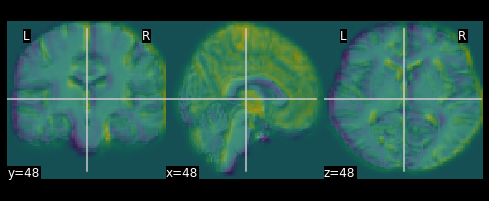

In [13]:
upsampled = LayerAttribution.interpolate(
    attr, (96, 96, 96), interpolate_mode="trilinear"
).cpu()
z_normed = z_norm(upsampled[0][0])

_nifti = lambda arr: nibabel.nifti1.Nifti1Image(arr, np.eye(4))

display = plotting.plot_anat(_nifti(x[0][0].detach().numpy()), cut_coords=cut_coords)
display.add_overlay(_nifti(z_normed.detach().numpy()), alpha=0.6)